# Lab12-2 Image Captioning

112501533 黃思誠

## Prepare environment

In [1]:
import glob
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm

# Constant
IMAGE_DIR = "./data/words_captcha"
ANNOTATION_PATH = "./data/spec_train_val.txt"
RANDOM_STATE = 0
IMAGE_SIZE = 416
TOP_K = 5000

BATCH_SIZE = 50
BUFFER_SIZE = 3000
EPOCH = 5
LEARNING_RATE = 1e-4

EMBEDDING_DIM = 256
UNITS = 512

AUTOTUNE = tf.data.experimental.AUTOTUNE


2023-11-28 22:23:06.229102: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 22:23:06.229127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 22:23:06.229141: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


## Load and preprocess data

1. Read annotation to get train_image_name, caption
2. Get train_image_path by train_image_name
3. Get test_image_path
4. Tokenize caption

In [3]:
def read_annotation():
    annotations = open(ANNOTATION_PATH).read().splitlines()

    # Split image name and caption
    annotations = [line.strip().split(" ") for line in annotations]
    image_names, captions = list(zip(*annotations))

    # Formatting the image name and caption
    image_names = [name + ".png" for name in image_names]
    image_paths = [os.path.join(IMAGE_DIR, name) for name in image_names]

    captions = ["<start> " + " ".join(list(cap)) + " <end>" for cap in captions]

    return image_paths, captions


image_paths, captions = read_annotation()
test_image_paths = set(glob.glob("./data/words_captcha/*.png")) - set(image_paths)
test_image_paths = list(test_image_paths)

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=TOP_K,
    oov_token="<unk>",
    filters=r'!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
)

# Fit tokenizer
tokenizer.fit_on_texts(captions)

# Create padding sequence
tokenizer.word_index["<pad>"] = 0
tokenizer.index_word[0] = "<pad>"

# Tokenize captions
cap_seq = tokenizer.texts_to_sequences(captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(cap_seq, padding="post")

max_length = max(len(cap) for cap in cap_vector)
vocab_size = len(tokenizer.word_index) + 1


## Create train, validation, test dataset

1. Split train, validation image_paths
2. Create three datasets

In [4]:
def load_image(image_path, cap=None):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img * 2 - 1
    return img, cap


image_paths, cap_vector = shuffle(image_paths, cap_vector, random_state=RANDOM_STATE)
img_paths_train, img_paths_val, cap_train, cap_val = train_test_split(
    image_paths, cap_vector, test_size=20000, random_state=RANDOM_STATE
)

# Train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((img_paths_train, cap_train))
train_dataset = (
    train_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((img_paths_val, cap_val))
val_dataset = (
    val_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

# Test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_dataset = (
    test_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)


## Create model

- Using EfficientNetV2B2 as feature extractor

In [5]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


base_model = tf.keras.applications.EfficientNetV2B2(
    include_top=False,
    weights="imagenet",
    include_preprocessing=False,
    input_tensor=tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
)
feature_extractor = tf.keras.Model(base_model.inputs, base_model.output)
encoder = CNN_Encoder(EMBEDDING_DIM)
decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, vocab_size)

feature_extractor.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 208, 208, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 208, 208, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 208, 208, 32)         0         ['stem_bn[0][0]']         

## Define loss function

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


## Create / Load the checkpoint

In [7]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(
    feature_extractor=feature_extractor,
    encoder=encoder,
    decoder=decoder,
    optimizer=optimizer,
    epoch=tf.Variable(0),
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
best_manager = tf.train.CheckpointManager(ckpt, "./checkpoints/best", max_to_keep=1)

if ckpt_manager.restore_or_initialize():
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")


Initializing from scratch.


## Define training step and evaluating step

In [8]:
@tf.function
def train_step(img, cap):
    batch_size = img.shape[0]
    hidden = decoder.reset_state(batch_size=batch_size)
    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]] * batch_size, 1)

    loss = 0
    with tf.GradientTape() as tape:
        features = feature_extractor(img)
        features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
        features = encoder(features)

        for i in range(1, cap.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(cap[:, i], predictions)
            dec_input = tf.expand_dims(cap[:, i], 1)

    trainable_variables = (
        feature_extractor.trainable_variables
        + encoder.trainable_variables
        + decoder.trainable_variables
    )
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss / int(cap.shape[1])


In [9]:
@tf.function
def predict(imgs):
    batch_size = imgs.shape[0]
    hidden = decoder.reset_state(batch_size=batch_size)
    outputs = tf.expand_dims([tokenizer.word_index["<start>"]] * batch_size, 1)
    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]] * batch_size, 1)

    features = feature_extractor(imgs)
    features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
    features = encoder(features)

    for _ in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predict_id = tf.argmax(predictions, axis=1, output_type=tf.int32)

        dec_input = tf.expand_dims(predict_id, 1)
        outputs = tf.concat([outputs, dec_input], axis=1)

    return outputs


def process_output(outputs):
    results = []
    for output in outputs:
        result = ""
        for s in output[1:]:
            word = tokenizer.index_word[s]
            if word == "<end>":
                break
            result += tokenizer.index_word[s]
        results.append(result)

    return results


def evaluate(dataset):
    correct = 0
    total = 0
    for imgs, caps in tqdm(dataset, desc="Evaluation"):
        preds = process_output(predict(imgs).numpy())
        caps = process_output(caps.numpy())

        for pred, cap in zip(preds, caps):
            total += 1
            if pred == cap:
                correct += 1

    return correct / total


## Training

In [10]:
train_size = tf.cast(len(train_dataset), tf.float32)
loss_record = []
acc_record = []

best_acc = 0
for _ in range(EPOCH):
    train_total_loss = 0
    ckpt.epoch.assign_add(1)

    # Training
    for img, cap in tqdm(train_dataset, desc="Training"):
        train_loss = train_step(img, cap)
        train_total_loss += train_loss

    # Validation
    val_acc = evaluate(val_dataset)

    if val_acc > best_acc:
        best_acc = val_acc
        best_manager.save(ckpt.epoch)

    train_total_loss /= train_size

    # Record loss
    loss_record.append(train_total_loss.numpy())
    acc_record.append(val_acc)

    ckpt_manager.save(ckpt.epoch)

    # Print loss
    print(f"Epoch {ckpt.epoch.numpy()}", end=" ")
    print(f"Training Loss {train_total_loss:.6f}", end=" ")
    print(f"Validation Accuracy {val_acc:.2f}")


Evaluation: 100%|██████████| 400/400 [00:36<00:00, 11.03it/s]


Epoch 1 Training Loss 0.267180 Validation Accuracy 0.99


Evaluation: 100%|██████████| 400/400 [00:34<00:00, 11.60it/s]


Epoch 2 Training Loss 0.007625 Validation Accuracy 0.98


Evaluation: 100%|██████████| 400/400 [00:34<00:00, 11.63it/s]


Epoch 3 Training Loss 0.010650 Validation Accuracy 0.94


Evaluation: 100%|██████████| 400/400 [00:33<00:00, 11.81it/s]


Epoch 4 Training Loss 0.002744 Validation Accuracy 0.99


Evaluation: 100%|██████████| 400/400 [00:33<00:00, 11.88it/s]


Epoch 5 Training Loss 0.003337 Validation Accuracy 1.00


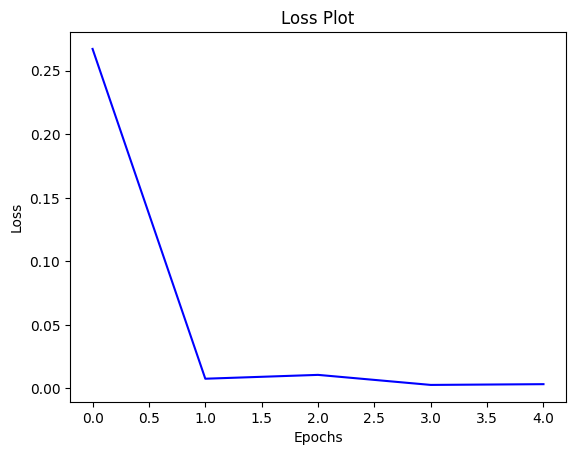

In [11]:
plt.plot(loss_record, color="blue", label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.show()


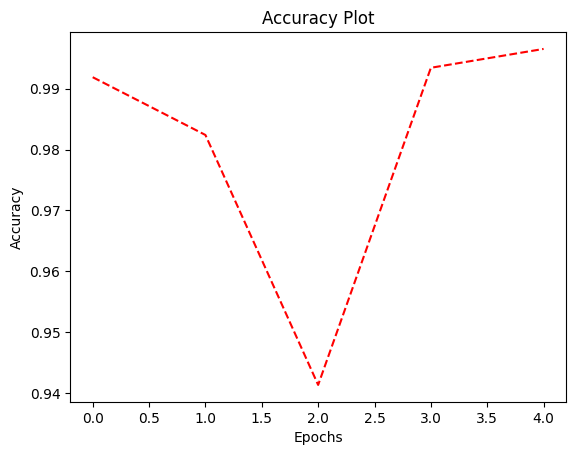

In [12]:
plt.plot(acc_record, color="red", label="Validation Acc", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Plot")
plt.show()


## Caculate the accuracy of validation image

In [13]:
ckpt.restore(best_manager.latest_checkpoint)
acc = evaluate(val_dataset)

print(f"Best Validation Accuracy {acc*100:.2f}%")


Evaluation: 100%|██████████| 400/400 [00:34<00:00, 11.61it/s]

Best Validation Accuracy 99.66%


## Predict the test image caption

In [14]:
fout = open("./output/prediction.txt", "w")
for i, (imgs, _) in enumerate(tqdm(test_dataset, desc="Predicting")):
    outputs = predict(imgs).numpy()
    results = process_output(outputs)

    image_names = [
        os.path.basename(path).split(".")[0]
        for path in test_image_paths[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
    ]

    for image_name, result in zip(image_names, results):
        fout.write(f"{image_name} {result}\n")

fout.close()


Predicting: 100%|██████████| 400/400 [00:34<00:00, 11.76it/s]
